# "Online Store Visitors Behavior Analysis"
> "Exploring 20M rows of online store"

- toc: false
- branch: master
- badges: true
- hide_github_badge: true
- comments: true
- categories: [pandas, EDA]
- image: images/ecommerce-analytics.jpg
- hide: false
- search_exclude: true
- metadata_key1: ecommerce_analysis
- metadata_key2: Pandas


A while ago, I found [this dataset](https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop) on **Kaggle** which contains 20M user events from an online store. it size over two Gigabite and the owner challenged data scientists to dig and find insights. so I toke this challenge.  
the dataset has been separated into five files, each file contains events for an entire month. starting from Octobor 2019 to Febrary 2020.

## Let's explore our data
We're going first to look at our data structure and prepare the data for analysis.

In [2]:
#collapse_show
# importing all necessary libraries for this analysis.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reading the data and taking a quick look at data structure.
oct_file = pd.read_csv(r'D:\My Files\Kaggle\2019-Oct.csv')
nov_file = pd.read_csv(r'D:\My Files\Kaggle\2019-Nov.csv')
dec_file = pd.read_csv(r'D:\My Files\Kaggle\2019-Dec.csv')
jan_file = pd.read_csv(r'D:\My Files\Kaggle\2020-Jan.csv')
feb_file = pd.read_csv(r'D:\My Files\Kaggle\2020-Feb.csv')
dataset = pd.concat([oct_file, nov_file, dec_file, jan_file, feb_file], ignore_index=True)
print(dataset.info())
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20692840 entries, 0 to 20692839
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 1.4+ GB
None


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9


&nbsp;  
The dataset has 9 columns and over 20M rows, each row contain users actions like adding to cart or viewing an item. at a glance, we see that our dataset needs some manipulation and cleaning. the `event_time` column has been signed as `object` data type, and we need to convert it to `DateTime` data type to make our life easier during analysis.  

In [3]:
#collapse_show
# changing event_time column from object to DateTime column
dataset['event_time'] = pd.to_datetime(dataset['event_time'])
# ckeck result and make sure the code worked fine
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20692840 entries, 0 to 20692839
Data columns (total 9 columns):
 #   Column         Dtype              
---  ------         -----              
 0   event_time     datetime64[ns, UTC]
 1   event_type     object             
 2   product_id     int64              
 3   category_id    int64              
 4   category_code  object             
 5   brand          object             
 6   price          float64            
 7   user_id        int64              
 8   user_session   object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(4)
memory usage: 1.4+ GB


&nbsp;  
Next we will check empty values.

In [4]:
#collapse_show
print('_______empty values_______\n', dataset.isna().sum())

_______empty values_______
 event_time              0
event_type              0
product_id              0
category_id             0
category_code    20339246
brand             8757117
price                   0
user_id                 0
user_session         4598
dtype: int64


&nbsp;  
The `category_code` and `brand` columns are 98% and 43% empty respectively, so we will get rid of them to make my cute machine fly faster.  
&nbsp;

In [5]:
#collapse_show
# dropping "category_code" and "brand" column
dataset.drop(columns=['category_code', 'brand'], inplace=True)

&nbsp;  
Lastly, let's check if there are any outliers so that we don't fall into that old mistake. **"garbage in -> garbage out"**
&nbsp;  
&nbsp;

In [12]:
#collapse_show
# counting number of events per user
dataset.groupby('user_id', as_index=False).agg(number_of_events=(
    'event_type', 'count')).nlargest(10, 'number_of_events')

,user_id,number_of_events
281608,527021202,26752
494091,557616099,9903
985991,583884978,9420
81834,419558969,8283
165553,476450673,8122
147504,467810091,8066
505313,557956487,7735
377367,550388516,7556
391614,552908674,7419
229928,506877330,6909


&nbsp;  
The first user have an enormous number of events which could mean that it's not human or one of the employees doing their work using a user account. possibilities are endless so we will exclude him anyway.

In [13]:
#collapse_show
# users list
outliers = [527021202]
# excluding outliers
clean_dataset = dataset[~dataset['user_id'].isin(outliers)]

___
## What are we looking for?
**Good analysis come out from good questions.** for any online store, the most important thing is <mark>__converstoin rate__</mark>. which basicly means: 
out of all visitors of the website, how many of them actually placed orders.  
therefore, we will build our analysis around that and try to find insights that can help the online store to understand their visitors behavior and make better campaigens.


### What is the current conversion rate?

__"if you can't measure it you can't manage it".__&nbsp; knowing the current state will help the stakeholders to measure whether if they are making any difference after using these analysis insights or not.

In [14]:
#collapse_show
# subsetting purchase events
# I found purchases with negative values, mostly it's returned orders.
purchases = clean_dataset.query('event_type == "purchase" & price > 0')

# counting the total number of orders
orders_count = len(purchases['user_session'].unique())

# counting number of visitors
visitors_count = len(clean_dataset['user_id'].unique())

# calculating conversion rate (number of orders / number of visitors)
conv_rate = round((orders_count / visitors_count),2)
print(f'Current conversoin rate is:\033[1m %{conv_rate}')

Current conversoin rate is: %0.09


which is below any industry average.
___

## When do users visit the online store?
Finding when users visit the store is crucial for digital market teams in many ways. the team can adjust their campaigns during these times which will lead to better targeting new customers and reduce the cost of their campaigns.  
In general, we want to know when users visit the store, and whether their behavior changes during weekends or not.

### Most active day of the week

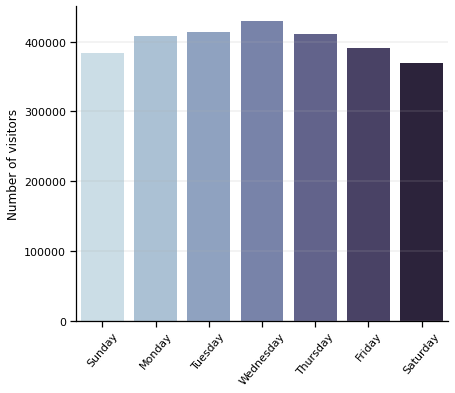

In [20]:
#collapse_show
# Create 'date' column
clean_dataset['date'] = clean_dataset['event_time'].dt.date
# unique users in each day
unieq_users = clean_dataset.drop_duplicates(subset=['user_id', 'date'])
# Create 'dayname' column to group by it
unieq_users['dayname'] = unieq_users['event_time'].dt.day_name()

# aggregating and visualizing data
days_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
sns.set_context('notebook')
v = sns.catplot(x='dayname', data=unieq_users, kind='count', 
                palette='ch:s=.25,rot=-.25',aspect=1.25, order=days_order)
v.set(xlabel='', ylabel='Number of visitors')
plt.grid(axis='y', linewidth=0.3)
plt.xticks(rotation=50)
plt.show()

Suprisengly, the most active days are the weekdays, not the weekends.

### What are the peak times
Let's be more specific and find out when do users visit the store during the day. we're going to split weekdays from the weekends since weekends tend to have different routines and potentially dissimilar behavior. 

In [16]:
#collapse_show
# Creating hour and 'day of week' column
clean_dataset['Hour'] = clean_dataset['event_time'].dt.hour
clean_dataset['d_of_week'] = clean_dataset['event_time'].dt.weekday
# tagging each event as 'Weekend' or 'Weekday' time
wends_wdays = []

for ind, row in clean_dataset.iterrows():
    if row['d_of_week'] < 5:
        wends_wdays.append('Weekday')
    else:
        wends_wdays.append('Weekend')

clean_dataset['Wend/Wday'] = wends_wdays

Now we visualize peak times.

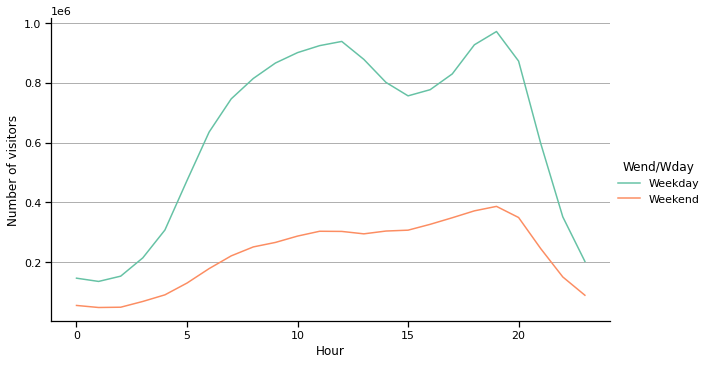

In [17]:
#collapse_show
# count the number of users per hour
peak_times = clean_dataset.groupby(['Hour', 'Wend/Wday'], as_index=False).agg(
    {'user_id': 'count'}).rename(columns={'user_id': 'Number of visitors'})

# plotting data
sns.set_context('notebook')
sns.relplot(data=peak_times, kind='line', x='Hour',
            y='Number of visitors', hue='Wend/Wday', palette='Set2', aspect=1.7)
plt.grid(axis='y')
plt.show()

We have slightly different behavior between weekends and weekdays, where weekdays have two peaks during the day, but both lines drop dramatically after 8 pm.
___

## Top 10 products
One of the ways to raise the conversion rate is to expand the range of the products. a key insight to that is to find top selling products and find expandable ones. now we will detect the top 10 products and their categories.

In [18]:
#collapse_show
# count top 10 products
top_products = purchases.groupby('product_id', as_index=False)[
    'event_type'].count().nlargest(10, 'event_type')
# subsetting 'product_id' & 'category_id' columns
prod_cat = purchases[[
    'product_id', 'category_id']].drop_duplicates('product_id')
# selecting top 10 products with their category
top_10 = prod_cat[prod_cat['product_id'].isin(
    top_products['product_id'])].reset_index(drop=True)
top_10.index += 1
top_10

,product_id,category_id
1,5700037,1487580009286598681
2,5751383,1487580005092295511
3,5751422,1487580005268456287
4,5815662,1487580006317032337
5,5849033,1487580005092295511
6,5809912,1602943681873052386
7,5854897,1487580009445982239
8,5802432,1487580009286598681
9,5304,1487580009471148064
10,5809910,1602943681873052386


out of the top 10 products, eight start with <mark>**148758**</mark> category ID, which represents the key number of the main category, and then the subcategory number comes after.  
___

## Average session duration
Another important KPI in ecommerce is the <mark>**average session duration**</mark>. a session is a group of user interactions with the website that take place within 30 minutes. sadly, the sessions of this store were not registered in the right way. many sessions lasted 151 days and others have 0-second duration as shown below. so we can not use this data in our analysis.

In [19]:
#collapse_show
# extracting start time and end time of each session
ses_st_end = clean_dataset.groupby('user_session', as_index=False).agg(
    min_=('event_time', 'min'), max_=('event_time', 'max'))
# subtract end from start to get session duration
ses_st_end['ses_duration'] = ses_st_end['max_'] - ses_st_end['min_']
# select only needed columns
ses_duration = ses_st_end.loc[:, ['user_session', 'ses_duration']].sort_values(
    'ses_duration', ascending=False).reset_index(drop=True)
ses_duration

,user_session,ses_duration
0,ae74cec4-ae31-4470-8484-84c3a75365d3,151 days 14:45:56
1,beac319a-88e8-43db-98e9-d6cd6184f444,151 days 11:10:49
2,099fefe4-a74c-4dae-b9c2-fe15dea34ff1,151 days 10:39:38
3,5b9bcf07-5c80-4f98-84dd-cad0883e0477,151 days 09:40:47
4,285e8547-29b3-49d2-b503-5ca9a60413cc,151 days 05:47:39
...,...,...
4518533,738a61cc-925e-48c8-ba6b-0ad258104504,0 days 00:00:00
4518534,738a6219-3a52-4915-a54b-2a75d3624a88,0 days 00:00:00
4518535,738a63f4-da1c-4f7b-8492-e2269d4f7c43,0 days 00:00:00
4518536,738a6949-bd26-4f23-8b26-7272f36eb3da,0 days 00:00:00


___
## Conclusions
The conversion rate tells us a lot about the store's performance. with a few little changes, the store can raise it without any additional costs. one of the ways is to create urgency feeling by using quantity countdown so the user act fast. also, adjusting campaigns during peak times on Sunday, Monday, and Tuesday will bring more visits to the store, either new visitors or retargeting current users. the store can focus on top-selling categories and reduce others while testing new categories in small quantities.  
data quality has some issues and the store data need to do some enhancement to have high-quality data to make better decisions in the future and a better understanding of visitors' behavior.